<a href="https://colab.research.google.com/github/ccarpenterg/LearningMXNet/blob/master/05_cifar_10_challenging_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR-10: A More Challenging Dataset for CNNs

In [0]:
!nvcc --version

In [0]:
!pip install mxnet-cu100

In [40]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

from mxnet.gluon.data.vision import transforms

import statistics

mx.random.seed(37373)

print(mx.__version__)

1.5.1


In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
])

CIFAR = gluon.data.vision.CIFAR10

train_data = CIFAR(train=True).transform_first(transform)
valid_data = CIFAR(train=False).transform_first(transform)

In [42]:
train_loader = gluon.data.DataLoader(train_data, shuffle=True, batch_size=64)
valid_loader = gluon.data.DataLoader(valid_data, shuffle=False, batch_size=64)


dataiter = iter(train_loader)

batch, labels = dataiter.__next__()

print(batch.shape)
print(labels.shape)

(64, 3, 32, 32)
(64,)


In [43]:
convnet = nn.Sequential()

convnet.add(
    nn.Conv2D(channels=32, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2),
    nn.Conv2D(channels=64, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2),
    nn.Conv2D(channels=64, kernel_size=3, activation='relu'),
    nn.Dense(64, activation='relu'),
    nn.Dense(10)
)

convnet

Sequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (5): Dense(None -> 64, Activation(relu))
  (6): Dense(None -> 10, linear)
)

In [44]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
convnet.initialize(mx.init.Xavier(), ctx=ctx)
convnet.summary(nd.zeros((64, 3, 32, 32), ctx=ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (64, 3, 32, 32)               0
        Activation-1                     <Symbol conv6_relu_fwd>               0
        Activation-2                            (64, 32, 30, 30)               0
            Conv2D-3                            (64, 32, 30, 30)             896
         MaxPool2D-4                            (64, 32, 15, 15)               0
        Activation-5                     <Symbol conv7_relu_fwd>               0
        Activation-6                            (64, 64, 13, 13)               0
            Conv2D-7                            (64, 64, 13, 13)           18496
         MaxPool2D-8                              (64, 64, 6, 6)               0
        Activation-9                     <Symbol conv8_relu_fwd>               0
       Activation-10        

In [0]:
trainer = gluon.Trainer(
    params=convnet.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.05, 'momentum': 0.5}
)

In [0]:
def train(model, loss_function, optimizer):
    
    train_batch_losses = []
    
    for batch, labels in train_loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        with autograd.record():
            output = model(batch)
            loss = loss_function(output, labels)
            
        loss.backward()
        
        optimizer.step(batch_size=batch.shape[0])
        
        train_batch_losses.append(float(nd.sum(loss).asscalar()))
        
    mean_loss = statistics.mean(train_batch_losses)
    
    return mean_loss

In [0]:
def validate(model, loss_function, optimizer):
    
    validation_batch_losses = []
    
    for batch, labels in valid_loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        output = model(batch)
        
        loss = loss_function(output, labels)
        
        validation_batch_losses.append(float(nd.sum(loss).asscalar()))
        
        mean_loss = statistics.mean(validation_batch_losses)
        
    return mean_loss

In [0]:
def accuracy(model, loader):
    
    metric = mx.metric.Accuracy()
    
    for batch, labels in loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        class_probabilities = nd.softmax(model(batch), axis=1)
        
        predictions = nd.argmax(class_probabilities, axis=1)
        
        metric.update(labels, predictions)
        
    _, accuracy_metric = metric.get()
    
    return accuracy_metric

In [0]:
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 16

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

epochs = range(1, num_epochs + 1)

for epoch in epochs:
    
    train_loss = train(convnet, loss_function, trainer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(convnet, train_loader)
    train_accuracies.append(train_accuracy)
    
    valid_loss = validate(convnet, loss_function, trainer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(convnet, valid_loader)
    valid_accuracies.append(valid_accuracy)
    
    print('Epoch {}/{}'.format(epoch, num_epochs))

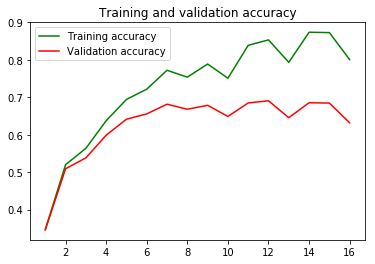

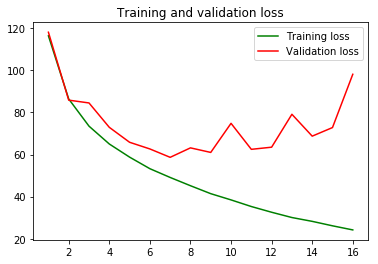

In [50]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
training_accuracy = 100 * accuracy(convnet, train_loader)
validation_accuracy = 100 * accuracy(convnet, valid_loader)

print('Training accuracy: {:5.2f}%'.format(training_accuracy))
print('Validation accuracy: {:5.2f}%'.format(validation_accuracy))

Training accuracy: 80.08%
Validation accuracy: 63.19%
